# QF605 Part III

###### Prepared By:  

Dani Pangestu  
Gabriel Woon  
Gabriel Tan  
Kenneth Chong  
Peter Chettiar  
Yong Wen

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq, least_squares
from scipy.stats import norm
from scipy.integrate import quad
from math import log, exp, sqrt
from scipy import interpolate
from scipy.interpolate import CubicSpline

In [2]:
#Black76 model used in obtaining IRR settled options
def Black76Lognormal(F, K, T, r, sigma, opt):
    d1 = (log(F/K)+(sigma*sigma/2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    if opt == 'Call':
        return F*exp(-r*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)
    elif opt == 'Put':
        return K*exp(-r*T)*norm.cdf(-d2) - F*exp(-r*T)*norm.cdf(-d1)
    
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

In [3]:
#Import LIBOR, OIS discount factors and Forward Libor rate from Part II
df_comb1 = pd.read_excel('df_comb.xlsx')
df_comb1.drop('Unnamed: 0',axis=1,inplace=True)
#df_comb1.set_index(keys = df_comb1.columns[0], drop = True, inplace=True)
df_comb1.head(15)

,Tenor,OIS_DF,Forward_LIBOR,LIBOR_DF
0,0.5,0.998752,0.025000,0.987654
1,1.0,0.997009,0.031005,0.972577
2,1.5,0.995270,0.031751,0.957378
3,2.0,0.993531,0.032263,0.942179
4,2.5,0.991773,0.034218,0.926330
5,3.0,0.990015,0.034814,0.910482
6,3.5,0.988066,0.035207,0.894731
7,4.0,0.986117,0.035838,0.878981
8,4.5,0.984150,0.034713,0.863985
9,5.0,0.982184,0.035326,0.848989


In [4]:
#Obtaining Forward LIBOR from discount factor
def F_LIBOR(D1,D2,delta):
    forward_LIBOR = (1/delta)*((D1-D2)/D2)
    return forward_LIBOR

#Obtaining Forward Swap rate
def Forward_SWAP_RATE(expiry, tenor, delta):   
    month = int(tenor/delta) #no. of payments
    float_leg, fixed_leg = 0, 0 #initialize fix and floating leg
#Floating Leg = OIS DF * Forward LIBOR * Delta    
    for i in range(1,month+1):
        loc = expiry + i*delta
        float_leg += OIS_DF(loc)*F_LIBOR(LIBOR_DF(loc-delta),LIBOR_DF(loc),delta)*delta
#Fixed Leg = Sum of OIS DF from Expiry to last Tenor
    for i in range(1,month+1):
        fixed_leg += OIS_DF(expiry + i*delta)*delta

    return float_leg/fixed_leg

In [5]:
df_alpha = pd.read_excel('df_comb.xlsx', sheet_name='alpha')
df_alpha.set_index("Unnamed: 0", inplace = True)
df_alpha.index.names = ['Expiry/Tenor']
df_alpha.columns = [1,2,3,5,10]
df_alpha.index = [1,5,10]

df_rho = pd.read_excel('df_comb.xlsx', sheet_name='rho')
df_rho.set_index("Unnamed: 0", inplace = True)
df_rho.index.names = ['Expiry/Tenor']
df_rho.columns = [1,2,3,5,10]
df_rho.index = [1,5,10]

df_nu = pd.read_excel('df_comb.xlsx', sheet_name='nu')
df_nu.set_index("Unnamed: 0", inplace = True)
df_nu.index.names = ['Expiry/Tenor']
df_nu.columns = [1,2,3,5,10]
df_nu.index = [1,5,10]

df_beta = pd.read_excel('df_comb.xlsx', sheet_name='beta')
df_beta.set_index("Unnamed: 0", inplace = True)
df_beta.index.names = ['Expiry/Tenor']

df_sigma = pd.read_excel('df_comb.xlsx', sheet_name='sigma')
df_sigma.set_index("Unnamed: 0", inplace = True)
df_sigma.index.names = ['Expiry/Tenor']

#### Interpolation

In [6]:
#Obtaining Libor Discount Factor through interpolation (Linear)
def LIBOR_DF(T):
    x = list(df_comb1['Tenor'])
    y = list(df_comb1['LIBOR_DF'])
    return np.interp(T, x, y)

#Obtaining OIS Discount Factor through interpolation (Linear)
def OIS_DF(T):
    x = list(df_comb1['Tenor'])
    y = list(df_comb1['OIS_DF'])
    return np.interp(T, x, y)

#Obtaining SABR parameters with Cubic Spline (Cubic Spline)
def ParamsCubicSpline (expiry, tenor, data):
    splied_from_expiry = []
    for i in [1,2,3,5,10]:
        result = CubicSpline([1, 5, 10], data[i], bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
        splied_from_expiry.append(result)

    extract = []
    for i in range(5):
        extract.append(splied_from_expiry[i](expiry))

    result = CubicSpline([1,2,3,5,10], extract, bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
    return float(result(tenor))

In [7]:
x_range = np.arange(1,10.1,0.1)

          1         2         3         5         10
1   0.139070  0.184646  0.196851  0.178052  0.171237
5   0.166509  0.199497  0.210346  0.191011  0.177441
10  0.177551  0.195043  0.207212  0.201519  0.180061


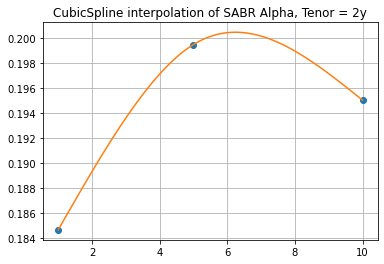

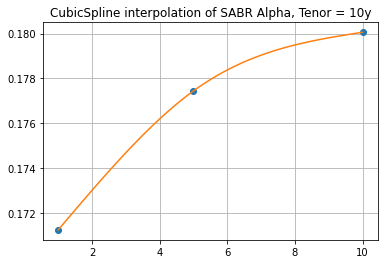

In [8]:
print(df_alpha)
plt.plot(df_alpha.index,df_alpha[2],"o")
plt.plot(x_range, [ParamsCubicSpline(x, 2, df_alpha) for x in x_range])
plt.title("CubicSpline interpolation of SABR Alpha, Tenor = 2y")
plt.grid()
plt.show()
plt.plot(df_alpha.index,df_alpha[10],"o")
plt.plot(x_range, [ParamsCubicSpline(x, 10, df_alpha) for x in x_range])
plt.title("CubicSpline interpolation of SABR Alpha, Tenor = 10y")
plt.grid()
plt.show()

          1         2         3         5         10
1  -0.633223 -0.525118 -0.482844 -0.414426 -0.265654
5  -0.585159 -0.546873 -0.549764 -0.511060 -0.440789
10 -0.545858 -0.543758 -0.550870 -0.562452 -0.506978


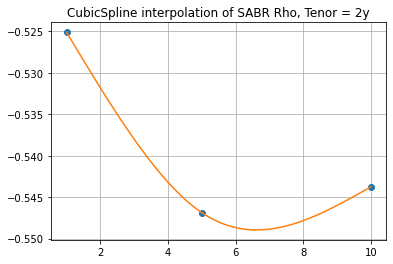

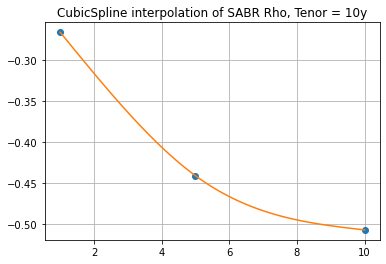

In [9]:
print(df_rho)
plt.plot(df_alpha.index,df_rho[2],"o")
plt.plot(x_range, [ParamsCubicSpline(x, 2, df_rho) for x in x_range])
plt.title("CubicSpline interpolation of SABR Rho, Tenor = 2y")
plt.grid()
plt.show()
plt.plot(df_alpha.index,df_rho[10],"o")
plt.plot(x_range, [ParamsCubicSpline(x, 10, df_rho) for x in x_range])
plt.title("CubicSpline interpolation of SABR Rho, Tenor = 10y")
plt.grid()
plt.show()

          1         2         3         5         10
1   2.049482  1.677437  1.438138  1.064877  0.776535
5   1.339619  1.061909  0.936718  0.671724  0.493849
10  1.007291  0.924810  0.869132  0.719875  0.579936


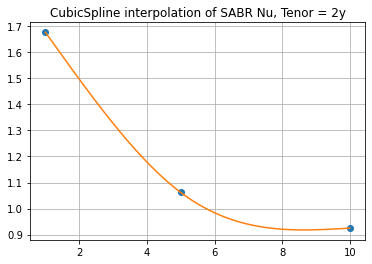

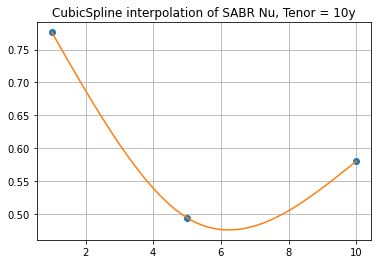

In [10]:
print(df_nu)
plt.plot(df_alpha.index,df_nu[2],"o")
plt.plot(x_range, [ParamsCubicSpline(x, 2, df_nu) for x in x_range])
plt.title("CubicSpline interpolation of SABR Nu, Tenor = 2y")
plt.grid()
plt.show()
plt.plot(df_alpha.index,df_nu[10],"o")
plt.plot(x_range, [ParamsCubicSpline(x, 10, df_nu) for x in x_range])
plt.title("CubicSpline interpolation of SABR Nu, Tenor = 10y")
plt.grid()
plt.show()

### Part 1: Using the SABR model calibrated in the previous question, value the following constant maturity swap (CMS) products:

• PV of a leg receiving CMS10y semi-annually over the next 5 years

• PV of a leg receiving CMS2y quarterly over the next 10 years


A constant maturity swap (CMS) pays a swap rate rather than a LIBOR rate
on its floating leg.

CMS products gives us an easy way to gain exposure to fixed-length longer-term interest rates by taking a view on a fixed point on the yield curve. This is in contrast with using IRS as exposure will become shorter over time as IRS shifts from the long end of the yield curve to the short end.


The standard practice in the market is to use the static-replication method to
obtain a model-independent convexity correction. By static-replication approach, and choosing the forward swap rate F = Sn,N (0) as our expansion
point, we can express this as:

\begin{equation}
\begin{aligned}
&V_{0}=D(0, T) g(F)+h^{\prime}(F)\left[V^{\text {pay }}(F)-V^{r e c}(F)\right] \\
&\quad+\int_{0}^{F} h^{\prime \prime}(K) V^{r e c}(K) d K+\int_{F^{\prime}}^{\infty} h^{\prime \prime}(K) V^{\text {pay }}(K) d K \\
&=D(0, T) g(F)+\int_{0}^{F} h^{\prime \prime}(K) V^{r e c}(K) d K+\int_{F}^{\infty} h^{\prime \prime}(K) V^{p a y}(K) d K
\end{aligned}
\end{equation}

#### IRR-settled option pricer (Vpay or Vrec) is given by:

\begin{equation}
V(K)=D(0, T) \cdot \operatorname{IRR}\left(S_{n, N}(0)\right) \cdot \operatorname{Black} 76\left(S_{n, N}(0), K, \sigma_{\mathrm{SABR}}, T\right)
\end{equation}

whereby the sigma for Black76 Model is derived for the SABR model above.


#### Obtaining $ h^{\prime \prime}(K) $ :

\begin{equation}
h^{\prime \prime}(K)=\frac{-\operatorname{IRR}^{\prime \prime}(K) \cdot K-2 \cdot \operatorname{IRR}^{\prime}(K)}{\operatorname{IRR}(K)^{2}}+\frac{2 \cdot \operatorname{IRR}^{\prime}(K)^{2} \cdot K}{\operatorname{IRR}(K)^{3}}
\end{equation}

In [11]:
#use prof code to calculate IRR whereby no need to use for loop
def IRR(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += Delta*(1 + K* Delta)**(-i)
    return total

def IRR_1st(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += (-i)*(Delta**2)*(1 + K* Delta)**(-i-1)
    return total

def IRR_2nd(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += (-i)*(-i-1)*(Delta**3)*(1 + K* Delta)**(-i-2)
    return total
 
def h_2nd(Tenor, Delta, K):
    IRR0 = IRR(Tenor, Delta, K)
    IRR1 = IRR_1st(Tenor, Delta, K)
    IRR2 = IRR_2nd(Tenor, Delta, K) 
    return (-IRR2*K - 2*IRR1) / (IRR0**2) + 2*(IRR1**2)*K/(IRR0**3)

def integrand(F, K, T, r, sigma, tenor, delta, opt):
    irr = IRR(tenor, delta, F)
    hppk = h_2nd(tenor, delta, K)
    return hppk*Black76Lognormal(F, K, T, r, sigma, opt)

#### CMS Rate written as:

$$ E^{T}\left[S_{n, N}(T)\right]=g(F)+\frac{1}{D_{0}(0, T)}\left[\int_{0}^{F} h^{\prime \prime}(K) V^{\text {rec }}(K) d K+\int_{F}^{\infty} h^{\prime \prime}(K) V^{\text {pay }}(K) d K\right] $$

In [12]:
def CMS(expiry, tenor, delta):
    F       = Forward_SWAP_RATE(expiry, tenor, delta)
    alpha   = ParamsCubicSpline(expiry,tenor,df_alpha)
    rho     = ParamsCubicSpline(expiry,tenor,df_rho)
    nu      = ParamsCubicSpline(expiry,tenor,df_nu)
    
    VRec     = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Put'), 0, F)
    VPay     = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Call'), F, 0.1) 
    
    return F + VRec[0] + VPay[0]

#### The PV of a CMS leg is the sum of the discounted values of the CMS rates, multiplied by the day count fraction.

\begin{equation}
C M S \operatorname{leg} P V=\sum_{i=0.5}^{N} D_{0}\left(0, T_{i}\right) * \operatorname{CMS}\left(S_{n, N}\left(T_{i}\right)\right) * \text { Date Count }
\end{equation}

In [13]:
def PV_CMS(tenor, cms_period, delta):
    n = int(cms_period/delta)
    pv = 0
    for i in range(1,n+1):
        loc = i*delta
        pv += OIS_DF(loc)*delta*CMS(loc,tenor,delta)
    return pv

In [14]:
cms_period = 5
tenor = 10
delta = 0.5
PV = PV_CMS(tenor, cms_period, delta)
print(f"The PV of a leg receiving CMS10y semi-annually over the next 5 years is {PV:.5f}.")

The PV of a leg receiving CMS10y semi-annually over the next 5 years is 0.20209.


In [15]:
cms_period = 10
tenor = 2
date_count_f = 0.25
PV = PV_CMS(tenor, cms_period, date_count_f)
print(f"The PV of a leg receiving CMS2y quarterly over the next 10 years is {PV:.5f}.")

The PV of a leg receiving CMS2y quarterly over the next 10 years is 0.38106.


### Part 2: Compare the forward swap rates with the CMS rate:

• 1y × 1y, 1y × 2y, 1y × 3y, 1y × 5y, 1y × 10y

• 5y × 1y, 5y × 2y, 5y × 3y, 5y × 5y, 5y × 10y

• 10y × 1y, 10y × 2y, 10y × 3y, 10y × 5y, 10y × 10y


In [16]:
#Obtaining CMS rates
Exipry = [1, 5, 10]
Tenor = [1, 2, 3, 5, 10]
delta = 0.5

CMS_list = []
for i in Exipry:
    for j in Tenor:
        CMS_list.append(CMS(i,j,delta))

In [17]:
#import SABR Implied Vol parameters data -> alpha, rho, nu
#df_SABRImpVol = pd.read_csv('df_SABRImpVol.csv')
#df_SABRImpVol.set_index(keys = df_SABRImpVol.columns[0], drop = True, inplace=True)

In [18]:
# fwdSwapRatesDF = pd.read_csv('fwdSwapRatesDF.csv')
fwdSwapRatesDF = pd.read_excel('df_comb.xlsx', sheet_name='forward swap rates')

In [19]:
fwdSwapRatesDF

,Start,Tenor,Forward Swap Rates
0,1,1,0.032007
1,1,2,0.033259
2,1,3,0.034011
3,1,5,0.035255
4,1,10,0.038428
5,5,1,0.039274
6,5,2,0.040075
7,5,3,0.040072
8,5,5,0.041093
9,5,10,0.043634


In [20]:
Index = ['1 x 1', '1 x 2', '1 x 3', '1 x 5', '1 x 10',
         '5 x 1', '5 x 2', '5 x 3', '5 x 5', '5 x 10',
         '10 x 1', '10 x 2', '10 x 3', '10 x 5', '10 x 10']

summary = pd.DataFrame({'CMS_rate':CMS_list, 'Forward_Swap_rate':fwdSwapRatesDF["Forward Swap Rates"].values }, index = Index)
summary['Difference'] = summary.CMS_rate - summary.Forward_Swap_rate
summary

,CMS_rate,Forward_Swap_rate,Difference
1 x 1,0.032120,0.032007,0.000113
1 x 2,0.033382,0.033259,0.000123
1 x 3,0.034120,0.034011,0.000109
1 x 5,0.035326,0.035255,0.000071
1 x 10,0.038496,0.038428,0.000068
5 x 1,0.040129,0.039274,0.000855
5 x 2,0.040756,0.040075,0.000681
5 x 3,0.040664,0.040072,0.000592
5 x 5,0.041532,0.041093,0.000439
5 x 10,0.044050,0.043634,0.000416


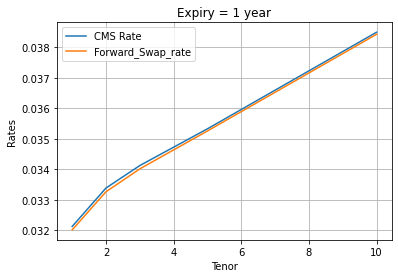

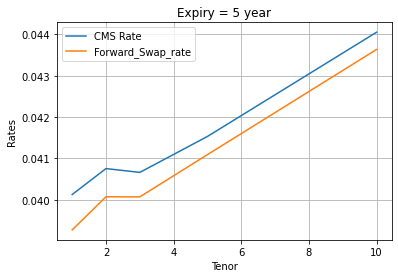

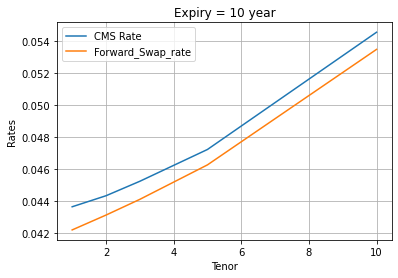

In [21]:
title_list = ['Expiry = 1 year', 'Expiry = 5 year', 'Expiry = 10 year']
for i in range(3):
    plt.plot(Tenor,summary["CMS_rate"][i*5:(i+1)*5],label="CMS Rate")
    plt.plot(Tenor,summary["Forward_Swap_rate"][i*5:(i+1)*5],label="Forward_Swap_rate")
    plt.title(title_list[i])
    plt.ylabel("Rates")
    plt.xlabel("Tenor")
    plt.legend()
    plt.grid()
    plt.show()